In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Jun  8 11:20:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 10.0 MB/s 
     |████████████████████████████████| 965 kB 44.3 MB/s 
     |████████████████████████████████| 235 kB 19.5 MB/s 
     |████████████████████████████████| 581 kB 16.4 MB/s 


In [ ]:
%tensorflow_version 2.x

In [ ]:
import pandas as pd
from itertools import chain
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import io
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import string
import re
from os.path import join
from underthesea import sent_tokenize,word_tokenize,pos_tag
from sklearn.metrics import *
from sklearn.utils.class_weight import compute_class_weight
from gensim.models import Word2Vec
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
train=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/train.csv")

In [ ]:
valid=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/valid.csv")

In [ ]:
train[train['sentence'].str.contains('. e12')]

,sentence,sentiment,topic


In [ ]:
punctuations=list(string.punctuation)
def normalizer(text,joinf=False):
  def remove_symbols(s):
    return re.sub(r'\b(colon\w+)\b'," ",s)

  def remove_fraction(s):
    return re.sub(r'\b(fraction)\b','/',s)

  def replace_dot(s):
    return s.replace('dot','.')
    # return re.sub(r'\b(dot)\b',".",s)

  def replace_doubledot(s):
    return s.replace('doubledot',':')
    
  def uncased(s):
    return s.lower()

  def fix_whitespaces(s):
    return re.sub(r'\s+',' ',s)

  def remove_entities(s):
    return re.sub(r'\b((\w+|)wzjwz\d+)\b'," ",s)

  def remove_vv(s):
    return s.replace('v.v'," ")

  def remove_punctuations(s):
      return ''.join(ch for ch in s if ch not in punctuations)
  def norm_major(s):
      majors={
          'cnpm':"công nghệ phần mềm",
          'khmt':"khoa học máy tính",
          'ktmt':"kĩ thuật máy tính",
          'cntt':"công nghệ thông tin",
          'av1':"anh văn 1",
          'av2':"anh văn 2",
          'av3':"anh văn 3"
      }
      for k,v in majors.items():
        s=re.sub(r'\b({})\b'.format(k),v,s)
      return s
  def remove_ps(s):
    return s.replace("p / s"," ")

  def tokenizer(text):
    tokens=[]
    pos_tags=[]
    for sent in sent_tokenize(text):
      tags=pos_tag(sent)
      for token in tags:
        if token[0] not in punctuations:
          tokens.append(uncased(token[0]))
          pos_tags.append(f'{uncased(token[0])}|{token[1]}')
          
    return tokens,pos_tags

  norm_text=fix_whitespaces(norm_major(remove_ps(remove_fraction(remove_vv(remove_entities(remove_symbols(replace_dot(replace_doubledot(text)))))))).strip())
  return tokenizer(norm_text)

In [ ]:
train_x=train['sentence'].tolist()
train_y=train['topic'].tolist()

In [ ]:
train_x=[normalizer(sample)for sample in train_x]

In [ ]:
train_x[0]

(['slide', 'giáo trình', 'đầy đủ'], ['slide|N', 'giáo trình|V', 'đầy đủ|A'])

In [ ]:
all_tokens=[s[0] for s in train_x]
all_tokens=list(chain.from_iterable(all_tokens))

In [ ]:
counter=Counter(all_tokens)

In [ ]:
counter.most_common(10)

[('thầy', 3048),
 ('sinh viên', 2684),
 ('dạy', 2162),
 ('và', 2068),
 ('không', 2058),
 ('rất', 1961),
 ('nhiệt tình', 1845),
 ('cho', 1724),
 ('có', 1708),
 ('nhiều', 1622)]

In [ ]:
x,y=list(range(1,len(counter)+1)),list(counter.values())


In [ ]:
def seq_len_visualizer(x,y):
  fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(5,5))
  ax.bar(x,y)
  fig.show()

(None, 3463, 1)

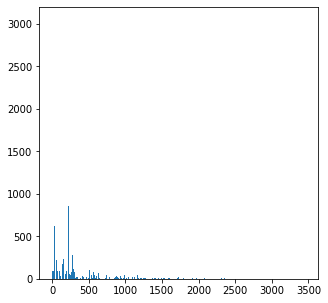

In [ ]:
seq_len_visualizer(x,y),max(x),min(x)

In [ ]:
all_pos_tags=[s[1] for s in train_x]
all_pos_tags=list(chain.from_iterable(all_pos_tags))

In [ ]:
counter=Counter(all_pos_tags)

In [ ]:
counter.most_common(10)

[('thầy|N', 3048),
 ('sinh viên|N', 2682),
 ('dạy|V', 2162),
 ('và|C', 2068),
 ('không|R', 2058),
 ('rất|R', 1961),
 ('có|V', 1702),
 ('nhiều|A', 1622),
 ('hiểu|V', 1568),
 ('cho|E', 1461)]

In [ ]:
x,y=list(range(1,len(counter)+1)),list(counter.values())

In [ ]:
def seq_len_visualizer(x,y):
  fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(5,5))
  ax.bar(x,y)
  fig.show()

(None, 4410, 1)

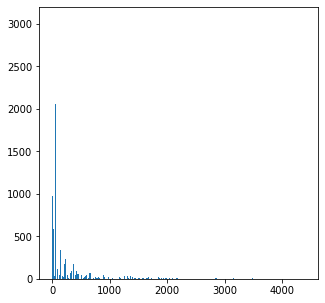

In [ ]:
seq_len_visualizer(x,y),max(x),min(x)

#Train word2vec

In [ ]:
min_count=1
window=3
size=300
alpha=1e-3
min_alpha=1e-4
negative=10
w2v_model = Word2Vec(min_count=min_count,window=window,size=size,alpha=alpha,min_alpha=min_alpha,negative=negative,sg=1)
p2v_model = Word2Vec(min_count=min_count,window=window,size=size,alpha=alpha,min_alpha=min_alpha,negative=negative,sg=1)

In [ ]:
word_sents=[sent[0] for sent in train_x]
pos_sents=[sent[1] for sent in train_x]

In [ ]:
w2v_model.build_vocab(word_sents)
p2v_model.build_vocab(pos_sents)

In [ ]:
w2v_model.train(word_sents, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1,compute_loss=True)
p2v_model.train(pos_sents, total_examples=p2v_model.corpus_count, epochs=100, report_delay=1,compute_loss=True)

(7915813, 10918300)

In [ ]:
w2v_model.get_latest_training_loss(),p2v_model.get_latest_training_loss()

(21762924.0, 23340306.0)

In [ ]:
w2v_model.wv.most_similar(word_sents[0][0]),word_sents[0][0]

([('bài giảng', 0.9128121733665466),
  ('đọc', 0.9052721858024597),
  ('giáo trình', 0.898164689540863),
  ('giao tiếp', 0.8775270581245422),
  ('bằng', 0.8635618686676025),
  ('việt', 0.8610875606536865),
  ('rõ ràng', 0.8555132150650024),
  ('to', 0.8393564224243164),
  ('up', 0.8383626937866211),
  ('tăng cường', 0.837610125541687)],
 'slide')

In [ ]:
p2v_model.wv.most_similar(pos_sents[0][0]),pos_sents[0][0]

([('giao tiếp|V', 0.9173514246940613),
  ('đọc|V', 0.9166379570960999),
  ('giáo trình|N', 0.9164043664932251),
  ('bài giảng|V', 0.912919282913208),
  ('việt|V', 0.9071084260940552),
  ('slide|V', 0.8985075950622559),
  ('bằng|E', 0.8934258222579956),
  ('to|A', 0.8917434215545654),
  ('rõ ràng|A', 0.8900977373123169),
  ('luyện|V', 0.8878583908081055)],
 'slide|N')

In [ ]:
wv=w2v_model.wv
pv=p2v_model.wv

In [ ]:
vocabs=['pad','unk']+list(wv.vocab.keys())
pos_tags=['pad','unk']+list(pv.vocab.keys())

In [ ]:
len(vocabs),len(pos_tags)

(3465, 4412)

In [ ]:
vocab2idx={vocab:idx for idx,vocab in enumerate(vocabs)}
pos2idx={pos:idx for idx,pos in enumerate(pos_tags)}

In [ ]:
vocab2idx['đầy đủ']

4

In [ ]:
w_weights=np.concatenate([np.random.uniform(low=-0.05,high=0.05,size=(2,300)),wv.vectors],axis=0)
w_weights.shape

(3465, 300)

In [ ]:
p_weights=np.concatenate([np.random.uniform(low=-0.05,high=0.05,size=(2,300)),pv.vectors],axis=0)
p_weights.shape

(4412, 300)

#Create inputs

In [ ]:
def create_input_ids(sample):
  _tokens=[]
  _pos_tags=[]
  tokens,pos_tags=normalizer(sample)

  for i in zip(tokens,pos_tags):
    if i[0] in vocab2idx:
      _tokens.append(vocab2idx[i[0]])
    else:
      _tokens.append(vocab2idx['unk'])

    if i[1] in pos2idx:
      _pos_tags.append(pos2idx[i[1]])
    else:
      _pos_tags.append(pos2idx['unk'])

  return _tokens,_pos_tags

In [ ]:
train_x=train['sentence'].tolist()
train_y=train['topic'].tolist()

In [ ]:
create_input_ids(train_x[0]),train_x[0]

(([2, 3, 4], [2, 3, 4]), 'slide giáo trình đầy đủ .')

In [ ]:
train_x=[create_input_ids(s) for s in train_x]

In [ ]:
words_train_x=[s[0] for s in train_x]
pos_tags_train_x=[s[1] for s in train_x]

In [ ]:
max_length=128

In [ ]:
words_train_x = tf.keras.preprocessing.sequence.pad_sequences(
    words_train_x, padding="post",maxlen=max_length)

pos_tags_train_x = tf.keras.preprocessing.sequence.pad_sequences(
    pos_tags_train_x, padding="post",maxlen=max_length)

In [ ]:
valid_x=valid['sentence'].tolist()
valid_y=valid['topic'].tolist()

In [ ]:
valid_x=[create_input_ids(s) for s in valid_x]

In [ ]:
words_valid_x=[s[0] for s in valid_x]
pos_tags_valid_x=[s[1] for s in valid_x]

In [ ]:
words_valid_x = tf.keras.preprocessing.sequence.pad_sequences(
    words_valid_x, padding="post",maxlen=max_length)

pos_tags_valid_x = tf.keras.preprocessing.sequence.pad_sequences(
    pos_tags_valid_x, padding="post",maxlen=max_length)

In [670]:
train_batch_size=16
train_dataloader=tf.data.Dataset.from_tensor_slices({'input_ids':words_train_x,'pos_ids':pos_tags_train_x,'labels':train_y})
train_dataloader=train_dataloader.batch(batch_size=train_batch_size)

In [671]:
valid_batch_size=16
valid_dataloader=tf.data.Dataset.from_tensor_slices({'input_ids':words_valid_x,'pos_ids':pos_tags_valid_x,'labels':valid_y})
valid_dataloader=valid_dataloader.batch(batch_size=valid_batch_size)

#Define model

In [672]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [673]:
LSTM_Layer = tf.compat.v1.keras.layers.CuDNNLSTM if tf.test.gpu_device_name()!="" else layers.LSTM
LSTM_Layer


keras.layers.cudnn_recurrent.CuDNNLSTM

In [674]:
class BiLSTMClassificier(tf.keras.Model):
  def __init__(self,embedding_dim,hidden_dim,num_vocabs,num_pos_tags,num_labels,drop_rate=0.1,word_embedding_weights=None,pos_embedding_weights=None):
    super(BiLSTMClassificier,self).__init__()

    self.embedding_dim=embedding_dim
    self.hidden_dim=hidden_dim
    self.num_vocabs=num_vocabs
    self.num_labels=num_labels
    self.drop_rate=drop_rate
    self.num_pos_tags=num_pos_tags
    self.word_embedding_weights=word_embedding_weights
    self.pos_embedding_weights=pos_embedding_weights

    if self.word_embedding_weights is not None:
      self.word_embedding_layer=layers.Embedding(self.num_vocabs,self.embedding_dim,
                                                  embeddings_initializer=tf.keras.initializers.Constant(self.word_embedding_weights),trainable=True)
    else:
      self.word_embedding_layer=layers.Embedding(self.num_vocabs,self.embedding_dim,trainable=True)

    if self.pos_embedding_weights is not None:
      self.pos_embedding_layer=layers.Embedding(self.num_pos_tags,self.embedding_dim,
                                                  embeddings_initializer=tf.keras.initializers.Constant(self.pos_embedding_weights),trainable=True)
    else:
      self.pos_embedding_layer=layers.Embedding(self.num_pos_tags,self.embedding_dim,trainable=True)

    self.embedding_layer=layers.Concatenate(axis=-1)

    self.forward_lstm_layer=LSTM_Layer(self.hidden_dim)

    self.backward_lstm_layer=LSTM_Layer(self.hidden_dim,go_backwards=True)

    self.bi_lstm_layer=layers.Bidirectional(layer=self.forward_lstm_layer,backward_layer=self.backward_lstm_layer)

    self.dropout_layer=layers.Dropout(self.drop_rate)

    self.linear=layers.Dense(self.num_labels)


  def call(self,input_ids,pos_ids,training=False):

    #shape of x: (batch_size,seq_len)

    word_embedding=self.word_embedding_layer(input_ids)
    pos_embedding=self.pos_embedding_layer(pos_ids)
    embedding_inputs=self.embedding_layer([word_embedding,pos_embedding])
    # embedding_inputs=word_embedding+pos_embedding


    # forward_lstm_inputs=self.forward_lstm_layer(embedding_inputs)
    # backward_lstm_inputs=self.backward_lstm_layer(embedding_inputs)
    bi_lstm_outputs=self.bi_lstm_layer(embedding_inputs)

    
    bi_lstm_outputs=self.dropout_layer(bi_lstm_outputs,training=training)

    logits=self.linear(bi_lstm_outputs)

    return logits

    

In [675]:
embedding_dim=300
hidden_dim=128
num_vocabs=len(vocabs)
num_pos_tags=len(pos_tags)
num_labels=4
drop_rate=0.4

model=BiLSTMClassificier(embedding_dim,hidden_dim,num_vocabs,num_pos_tags,num_labels,
                         drop_rate=drop_rate,word_embedding_weights=w_weights,pos_embedding_weights=p_weights)

In [676]:
for batch in train_dataloader:
  print(batch)
  break

{'input_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[  2,   3,   4, ...,   0,   0,   0],
       [  5,   6,   7, ...,   0,   0,   0],
       [ 10,  11,   4, ...,   0,   0,   0],
       ...,
       [ 64, 101,  93, ...,   0,   0,   0],
       [105,  22,   9, ...,   0,   0,   0],
       [118, 119, 120, ...,   0,   0,   0]], dtype=int32)>, 'pos_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[  2,   3,   4, ...,   0,   0,   0],
       [  5,   6,   7, ...,   0,   0,   0],
       [ 10,  11,   4, ...,   0,   0,   0],
       ...,
       [ 64, 102,  94, ...,   0,   0,   0],
       [106, 107,   9, ...,   0,   0,   0],
       [120, 121, 122, ...,   0,   0,   0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 0, 1, 0, 0, 0, 3, 1, 1, 1, 0, 3, 0, 1, 1, 3], dtype=int32)>}


In [677]:
for batch in valid_dataloader:
  print(batch)
  break

{'input_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[   3,   15,  154, ...,    0,    0,    0],
       [  25,  283,    0, ...,    0,    0,    0],
       [ 304,  280,  226, ...,    0,    0,    0],
       ...,
       [ 466, 1055,    0, ...,    0,    0,    0],
       [ 114,   76,  728, ...,    0,    0,    0],
       [ 214,   90,  198, ...,    0,    0,    0]], dtype=int32)>, 'pos_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[ 322,   15,  159, ...,    0,    0,    0],
       [ 235,  301,    0, ...,    0,    0,    0],
       [ 325,  298,  280, ...,    0,    0,    0],
       ...,
       [ 505, 1721,    0, ...,    0,    0,    0],
       [ 116,  153,  808, ...,    0,    0,    0],
       [ 225,   91, 1497, ...,    0,    0,    0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0], dtype=int32)>}


In [678]:
# lr=1e-5
# epsilon=1e-8
# # decay=0
# optimizer=tf.keras.optimizers.Adam(learning_rate=lr,epsilon=epsilon)

optimizer=tf.keras.optimizers.SGD(learning_rate=0.02)

In [679]:
class_weight=tf.constant(compute_class_weight(class_weight='balanced',y=train_y,classes=[0,1,2,3]),dtype=tf.float32)

In [680]:
class_weight

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.34980407, 1.2978191 , 5.7474847 , 5.0827403 ], dtype=float32)>

In [681]:
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)#,reduction=tf.keras.losses.Reduction.NONE)

In [682]:
train_step_signature= [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, ), dtype=tf.int32),
]


@tf.function(input_signature=train_step_signature)
def train_step(input_ids,pos_ids,labels):
  
  with tf.GradientTape() as tape:

    logits= model(input_ids=input_ids,pos_ids=pos_ids,training = True)
    probs=tf.nn.softmax(logits,axis=-1)
    # weighted_logits=tf.multiply(probs,class_weight)
    loss=loss_fn(labels,probs)
    
    # loss=tf.multiply(losses,sample_weight)
    # loss=tf.reduce_mean(loss,axis=-1)



  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss,probs

In [683]:
def test_step(input_ids,pos_ids,labels):
  logits= model(input_ids=input_ids,pos_ids=pos_ids,training = False)

  probs=tf.nn.softmax(logits,axis=-1)
  # weighted_logits=tf.multiply(probs,class_weight)
  loss=loss_fn(labels,probs)
  # loss=tf.multiply(losses,sample_weight)
  # loss=tf.reduce_mean(loss,axis=-1)

  return loss,probs

In [684]:
ckpt_path = "/content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden"
max_to_keep=5

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=max_to_keep)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f'Loading the latest checkpoint from {ckpt_manager.latest_checkpoint}')
else:
  print('Initializing the new checkpoint')

Initializing the new checkpoint


#Train

In [685]:
epochs=100

In [686]:
# min_loss=np.inf
best_acc=0
train_losses=[]
valid_losses=[]
train_accs=[]
valid_accs=[]
count_stopping=0

for epoch in range(epochs):
  bar=tqdm(train_dataloader)

  """TRAINING"""
  train_loss=0
  y_true=[]
  y_pred=[]
  for batch in train_dataloader:
    y_true.append(batch['labels'].numpy())
    loss,probs=train_step(batch['input_ids'],batch['pos_ids'],batch['labels'])
    loss=loss.numpy()
    train_loss+=loss
    pred=tf.argmax(probs,axis=-1)
    
    y_pred.append(pred.numpy())
    bar.set_postfix({f'train_loss_per_batch':loss})
    bar.update()
  
  train_loss/=len(train_dataloader)
  y_true=np.concatenate(y_true,axis=0)
  y_pred=np.concatenate(y_pred,axis=0)
  train_acc=accuracy_score(y_true,y_pred)

  """Validation"""
  valid_loss=0
  y_true=[]
  y_pred=[]
  for batch in valid_dataloader:
    y_true.append(batch['labels'].numpy())
    loss,probs=test_step(batch['input_ids'],batch['pos_ids'],batch['labels'])
    pred=tf.argmax(probs,axis=-1)
    y_pred.append(pred.numpy())
    loss=loss.numpy()
    valid_loss+=loss
  valid_loss/=len(valid_dataloader)
  y_true=np.concatenate(y_true,axis=0)
  y_pred=np.concatenate(y_pred,axis=0)
  valid_acc=accuracy_score(y_true,y_pred)
  print(f'epoch: {epoch} train_loss: {train_loss} train_acc: {train_acc} valid_loss: {valid_loss} valid_acc: {valid_acc}')
  
  # if min_loss>valid_loss:
  if best_acc<valid_acc:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch} at {ckpt_save_path}')
    best_acc=valid_acc
    # min_loss=valid_loss
    count_stopping=0
  else:
    count_stopping+=1

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accs.append(train_acc)
  valid_accs.append(valid_acc)

  if count_stopping>5:
    break

  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 0 train_loss: 0.8070669530988573 train_acc: 0.7150358830736916 valid_loss: 0.7919101110010436 valid_acc: 0.7271004421983576
Saving checkpoint for epoch 0 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-1


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 1 train_loss: 0.7132394157923185 train_acc: 0.7264134430246806 valid_loss: 0.7380177950618243 valid_acc: 0.7271004421983576


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 2 train_loss: 0.6393748822537335 train_acc: 0.7516191143007177 valid_loss: 0.694365190887692 valid_acc: 0.7327858496525584
Saving checkpoint for epoch 2 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-2


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 3 train_loss: 0.5818133737240638 train_acc: 0.7758620689655172 valid_loss: 0.6610849342412419 valid_acc: 0.7384712571067593
Saving checkpoint for epoch 3 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-3


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 4 train_loss: 0.5358026119899917 train_acc: 0.7941536845790302 valid_loss: 0.6511157320605384 valid_acc: 0.7466835123183828
Saving checkpoint for epoch 4 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-4


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 5 train_loss: 0.5055251197902473 train_acc: 0.8070190792928409 valid_loss: 0.5901336934831407 valid_acc: 0.7624763108022742
Saving checkpoint for epoch 5 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-5


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 6 train_loss: 0.4785574006242352 train_acc: 0.8141081743392263 valid_loss: 0.5381251870833262 valid_acc: 0.7820593809222994
Saving checkpoint for epoch 6 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-6


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 7 train_loss: 0.4564860352790439 train_acc: 0.8271486084368983 valid_loss: 0.49361307241699914 valid_acc: 0.7965887555274794
Saving checkpoint for epoch 7 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-7


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 8 train_loss: 0.4353647642827534 train_acc: 0.8373008927008577 valid_loss: 0.47473675456613 valid_acc: 0.8085912823752369
Saving checkpoint for epoch 8 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-8


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 9 train_loss: 0.41779996557356597 train_acc: 0.8461403815858568 valid_loss: 0.4584775131308671 valid_acc: 0.8161718256475048
Saving checkpoint for epoch 9 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-9


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 10 train_loss: 0.4050534446443711 train_acc: 0.8523542797129354 valid_loss: 0.42555702425012687 valid_acc: 0.8351231838281743
Saving checkpoint for epoch 10 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-10


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 11 train_loss: 0.3898851330984722 train_acc: 0.8575179415368458 valid_loss: 0.414348946112876 valid_acc: 0.83575489576753
Saving checkpoint for epoch 11 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-11


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 12 train_loss: 0.38306611339737484 train_acc: 0.8640819184316472 valid_loss: 0.40472697079031156 valid_acc: 0.8458622867972204
Saving checkpoint for epoch 12 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-12


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 13 train_loss: 0.3735594518560838 train_acc: 0.8658323122702608 valid_loss: 0.39300528691724096 valid_acc: 0.852179406190777
Saving checkpoint for epoch 13 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-13


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 14 train_loss: 0.36408421645214506 train_acc: 0.8697706984071416 valid_loss: 0.39515446743579824 valid_acc: 0.8490208464939988


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 15 train_loss: 0.35758468677009736 train_acc: 0.8730089270085769 valid_loss: 0.3846404439948424 valid_acc: 0.8578648136449779
Saving checkpoint for epoch 15 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-14


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 16 train_loss: 0.35067996925094747 train_acc: 0.8751093996149134 valid_loss: 0.3816738033836538 valid_acc: 0.8566013897662665


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 17 train_loss: 0.34582760151137004 train_acc: 0.8769473131454577 valid_loss: 0.3886986676641185 valid_acc: 0.8496525584333544


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 18 train_loss: 0.33912169390937663 train_acc: 0.8806231402065464 valid_loss: 0.3775927409002877 valid_acc: 0.8553379658875553


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 19 train_loss: 0.3360554247573539 train_acc: 0.8779100297566953 valid_loss: 0.3761549906598197 valid_acc: 0.8559696778269109


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 20 train_loss: 0.3286907230588523 train_acc: 0.8814108174339226 valid_loss: 0.374310194204251 valid_acc: 0.8610233733417562
Saving checkpoint for epoch 20 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-15


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 21 train_loss: 0.3237980719707854 train_acc: 0.8833362506563976 valid_loss: 0.3717061850533943 valid_acc: 0.8578648136449779


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 22 train_loss: 0.320147747986696 train_acc: 0.886311920182041 valid_loss: 0.3702636639954466 valid_acc: 0.8616550852811118
Saving checkpoint for epoch 22 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-16


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 23 train_loss: 0.31808033800729507 train_acc: 0.8871871171013478 valid_loss: 0.3730871882477794 valid_acc: 0.8597599494630449


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 24 train_loss: 0.31194627283701115 train_acc: 0.8867495186416944 valid_loss: 0.370327622751997 valid_acc: 0.8610233733417562


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 25 train_loss: 0.3091476176754682 train_acc: 0.8900752669350603 valid_loss: 0.36997636810246143 valid_acc: 0.86481364497789
Saving checkpoint for epoch 25 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-17


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 26 train_loss: 0.30268371969305136 train_acc: 0.8917381410817434 valid_loss: 0.3711087247638991 valid_acc: 0.8635502210991788


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 27 train_loss: 0.29774464154746255 train_acc: 0.894626290915456 valid_loss: 0.3643512445492576 valid_acc: 0.8654453569172458
Saving checkpoint for epoch 27 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-18


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 28 train_loss: 0.29811683759301694 train_acc: 0.8940136530719411 valid_loss: 0.3598182038451084 valid_acc: 0.86481364497789


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 29 train_loss: 0.29345866857109576 train_acc: 0.896551724137931 valid_loss: 0.3691743679269396 valid_acc: 0.8641819330385344


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 30 train_loss: 0.2899510732936588 train_acc: 0.8969893225975845 valid_loss: 0.3677903311421173 valid_acc: 0.8635502210991788


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 31 train_loss: 0.2853866994967098 train_acc: 0.8980395589007527 valid_loss: 0.3649329819688291 valid_acc: 0.8654453569172458


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 32 train_loss: 0.2837397105164722 train_acc: 0.8997024330474357 valid_loss: 0.365665996052099 valid_acc: 0.8641819330385344


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 33 train_loss: 0.2790249475300755 train_acc: 0.9003150708909504 valid_loss: 0.3679455739229616 valid_acc: 0.8629185091598232


#Visualize

In [687]:
def visualizer(x,y,y_label):
  fig,ax=plt.subplots(1,1)
  ax.plot(x)
  ax.plot(y)
  ax.set_xlabel('epoch')
  ax.set_ylabel(y_label)
  
  # ax2.plot(valid_losses)
  # ax2.set_xlabel('epoch')
  # ax2.set_ylabel('valid_loss')
  
  fig.show()

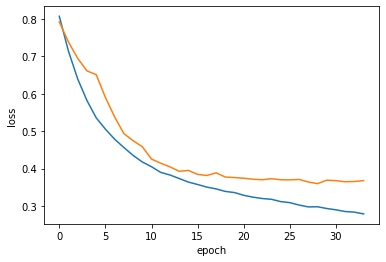

In [688]:
visualizer(train_losses,valid_losses,'loss')

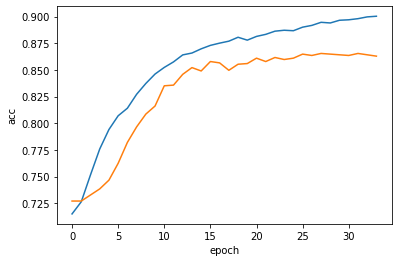

In [689]:
visualizer(train_accs,valid_accs,'acc')

#Inference

In [690]:
test=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/test.csv")

In [691]:
test_x=test['sentence'].tolist()
test_y=test['topic'].tolist()

In [692]:
embedding_dim=300
hidden_dim=128
num_vocabs=len(vocabs)
num_pos_tags=len(pos_tags)
num_labels=4
drop_rate=0.1

model=BiLSTMClassificier(embedding_dim,hidden_dim,num_vocabs,num_pos_tags,num_labels,
                         drop_rate=drop_rate)

In [693]:
ckpt_path = "/content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/"
max_to_keep=5

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=max_to_keep)

In [694]:
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f'Loading the latest checkpoint from {ckpt_manager.latest_checkpoint}')
else:
  print('Initializing the new checkpoint')

Loading the latest checkpoint from /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-18


In [695]:
test_pred=[]
bar=tqdm(test_x)
for sample in test_x:

  inputs=[create_input_ids(sample)]
  input_ids=tf.constant([i[0] for i in inputs],dtype=tf.int32)
  pos_ids=tf.constant([i[1] for i in inputs],dtype=tf.int32)

  
  
  logits=model(input_ids=input_ids,pos_ids=pos_ids,training=False)
  probs=tf.nn.softmax(logits,axis=-1)
  label=tf.argmax(probs,axis=-1)
  test_pred.append(label.numpy())
  bar.update()
  

  0%|          | 0/3166 [00:00<?, ?it/s]

In [696]:
print(classification_report(test_y,test_pred,digits=5))

              precision    recall  f1-score   support

           0    0.90337   0.95939   0.93054      2290
           1    0.75192   0.68357   0.71612       572
           2    0.81366   0.90345   0.85621       145
           3    0.54717   0.18239   0.27358       159

    accuracy                        0.86797      3166
   macro avg    0.75403   0.68220   0.69411      3166
weighted avg    0.85401   0.86797   0.85540      3166



In [697]:
confusion_matrix(test_y,test_pred)

array([[2197,   80,    5,    8],
       [ 153,  391,   14,   14],
       [   4,    8,  131,    2],
       [  78,   41,   11,   29]])